## 参考资料

* ndarray文档  
[https://mxnet.incubator.apache.org/api/python/ndarray.html](https://mxnet.incubator.apache.org/api/python/ndarray.html)

* yield用法  
[https://www.ibm.com/developerworks/cn/opensource/os-cn-python-yield/](https://www.ibm.com/developerworks/cn/opensource/os-cn-python-yield/)

* matplotlib用法  
[https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.plot.html](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.plot.html)  
[https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html)

* 指数平滑法  
[http://blog.csdn.net/tz_zs/article/details/78341306](http://blog.csdn.net/tz_zs/article/details/78341306)  
[http://blog.csdn.net/cl1143015961/article/details/41081183](http://blog.csdn.net/cl1143015961/article/details/41081183)

In [ ]:
# 导入mxnet的ndarray, autograd
from mxnet import autograd
from mxnet import ndarray as nd

## 创建数据集

In [2]:
# 训练数据的维度
num_inputs = 2

# 训练数据的样本数量
num_examples = 1000

# 实际的权重w
true_w = [2, -3.4]

# 实际的偏置b
true_b = 4.2

# 随机生成均值为0, 方差为1, 服从正态分布的训练数据X, 
X = nd.random_normal(shape=(num_examples, num_inputs))

# 根据X, w, b生成对应的输出y
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b 

# 给y加上随机噪声
y += 0.01 * nd.random_normal(shape=y.shape)

## 数据可视化

In [3]:
print(X[0], y[0])

(
[ 1.16307867  0.48380461]
<NDArray 2 @cpu(0)>, 
[ 4.87962484]
<NDArray 1 @cpu(0)>)


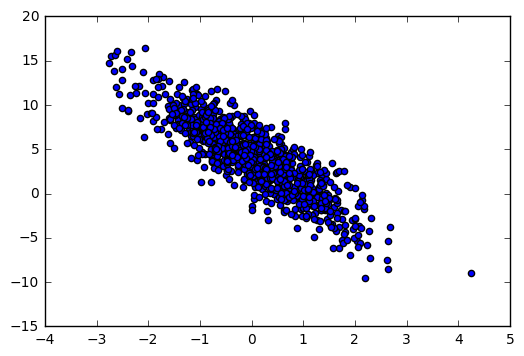

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制数据的散点图 
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())
plt.show()

## 数据读取

In [5]:
import random

# 训练时的批数据大小
batch_size = 10

# 通过yield进行数据读取
def data_iter():
    # 产生样本的索引
    idx = list(range(num_examples))
    # 将索引随机打乱
    random.shuffle(idx)
    # 迭代一个epoch, xrange循环时效率比range更高
    for i in xrange(0, num_examples, batch_size):
        # 依次取出样本的索引, 这种实现方式在num_examples/batch_size不能整除时也适用
        j = nd.array(idx[i:min((i + batch_size), num_examples)])
        # 根据提供的索引取元素
        yield nd.take(X, j), nd.take(y, j)

In [6]:
# 查看data_iter是否是generator函数
from inspect import isgeneratorfunction 
print isgeneratorfunction(data_iter)

# data_iter类似于类的定义, 而data_iter()相当于一个类的实例, 当然是匿名实例
import types 
print isinstance(data_iter(), types.GeneratorType)

# 读取数据测试
for data, label in data_iter():
    print(data, label)
    break

True
True
(
[[ 0.84884137  0.26954138]
 [-0.2433725  -0.55600822]
 [-0.98376983 -0.45507264]
 [-1.49418294 -1.61555624]
 [-0.05115514 -1.60389435]
 [-0.46684036 -1.07210052]
 [-0.41475967 -1.29824126]
 [ 1.51091301  0.12707268]
 [ 0.425275   -0.37855875]
 [ 0.93141842 -0.7470997 ]]
<NDArray 10x2 @cpu(0)>, 
[ 4.97207165  5.609725    3.7833426   6.69815683  9.56626606  6.90305567
  7.77388573  6.78652811  6.33143234  8.58629704]
<NDArray 10 @cpu(0)>)


## 初始化模型参数

In [7]:
# 随机初始化权重w
w = nd.random_normal(shape=(num_inputs, 1))
# 偏置b初始化为0
b = nd.zeros((1,))
# w, b放入list里
params = [w, b]

# 需要计算反向传播, 添加自动求导
for param in params:
    param.attach_grad()

## 定义模型

In [8]:
# 定义运算y = w * x + b
def net(X):
    # 向量, 矩阵乘用dot
    return nd.dot(X, w) + b

## 损失函数

In [9]:
# 定义平方损失
def square_loss(yhat, y):
    # 注意这里我们把y变形成yhat的形状来避免矩阵形状的自动转换
    # loss为预测值减去真实值
    return (yhat - y.reshape(yhat.shape)) ** 2

## 优化

In [10]:
# 定义随机梯度下降法
def SGD(params, lr):
    # 对参数进行梯度下降
    for param in params:
        # 这样写不会创建新的param, 而是会写在原来的param里, 新的param没有梯度
        param[:] = param - lr * param.grad

## 数据可视化

In [11]:
# 模型函数
def real_fn(X):
    return true_w[0] * X[:, 0] - true_w[1] * X[:, 1] + true_b

# 绘制损失随训练迭代次数变化的折线图，以及预测值和真实值的散点图
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    # 绘制两个子图
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # 子图一设置标题
    ax1.set_title('Loss during training')
    # 绘制loss图像, 蓝色实线
    ax1.plot(xs, losses, '-b')
    # 子图二设置标题
    ax2.set_title('Estimated vs Real Function')
    # 绘制预测值, 蓝色的小圈
    ax2.plot(X[:sample_size, 0].asnumpy(), net(X[:sample_size, :]).asnumpy(), 'ob', label = 'Estimated')
    # 绘制实际值, 绿色的星号
    ax2.plot(X[:sample_size, 0].asnumpy(), real_fn(X[:sample_size, :]).asnumpy(), '*g', label = 'Real Value')
    # 绘制图例
    ax2.legend()
    # 显示图像
    plt.show()

## 训练

Epoch 0, batch 99. Moving average of loss: 0.377771620176. Average loss: 0.624130


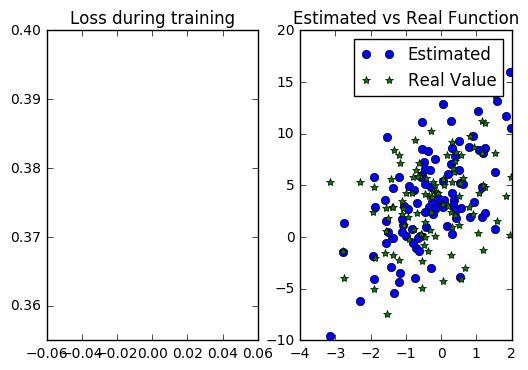

Epoch 1, batch 199. Moving average of loss: 0.10086550409. Average loss: 0.000100


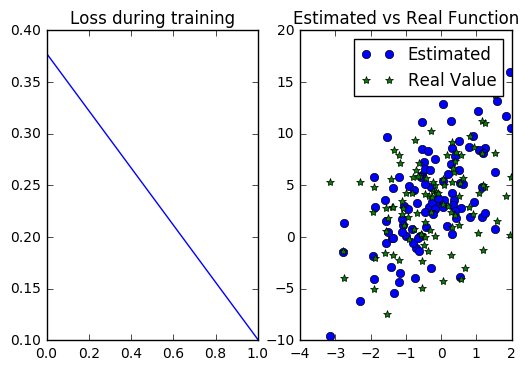

Epoch 2, batch 299. Moving average of loss: 0.033653873664. Average loss: 0.000099


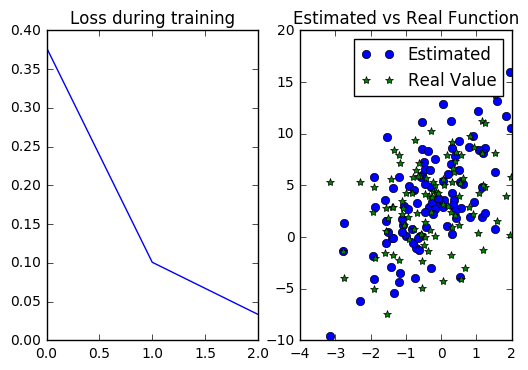

Epoch 3, batch 399. Moving average of loss: 0.0119900604556. Average loss: 0.000100


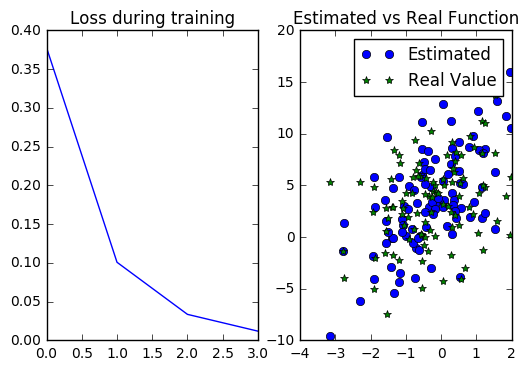

Epoch 4, batch 499. Moving average of loss: 0.00439972312788. Average loss: 0.000098


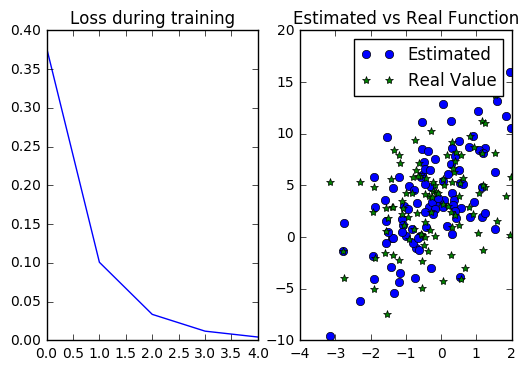

In [12]:
# 定义训练的迭代周期
epochs = 5
# 定义学习率
learning_rate = 0.01
# 迭代次数
niter = 0
# 保存loss
losses = []
# 移动平均损失（加权）
moving_loss = 0
# 指数平滑系数
smoothing_constant = 0.01

# 训练
for epoch in xrange(epochs):
    # 总的loss
    total_loss = 0
    # 迭代训练
    for data, label in data_iter():
        # 记录梯度
        with autograd.record():
            # 计算预测值
            output = net(data)
            # 计算loss
            loss = square_loss(output, label)
        # 根据loss进行反向传播计算梯度
        loss.backward()
        # 使用随机梯度下降求解(BSGD)
        SGD(params, learning_rate)
        # 计算总的loss
        total_loss += nd.sum(loss).asscalar()
        
        # 记录每读取一个数据点后，损失的移动平均值的变化
        # 迭代次数加一
        niter += 1
        # 计算当前损失
        current_loss = nd.mean(loss).asscalar()
        # 计算移动平均损失，指数平滑方法
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * current_loss
        # 计算估计损失
        est_loss = moving_loss / (1 - (1 - smoothing_constant) ** niter)
        
        # 输出迭代信息
        if (niter + 1) % 100 == 0:
            # 保存估计损失
            losses.append(est_loss)
            print 'Epoch %s, batch %s. Moving average of loss: %s. Average loss: %f' % (epoch, niter, est_loss, total_loss / num_examples)
            plot(losses, X)

In [13]:
print w 
print true_w
print b
print true_b


[[ 1.99951661]
 [-3.40126157]]
<NDArray 2x1 @cpu(0)>
[2, -3.4]

[ 4.20096636]
<NDArray 1 @cpu(0)>
4.2
